In [19]:
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
from kam11.matchedFilter import mf_bytime
from kam11.time_beamforming import beamform, beamform_attime
from kam11.plotting.mfPlotting import plotMultipleChannel, plot_ts
from kam11.plotting.beamformer import plot_beamformer
from kam11.thermister import getSoundSpeed
from os.path import join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
timeOfInterest='2011 J184 03:51:15'
loadDuration=dt.timedelta(0,5)
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M:%S')
savefolder = '/Users/edwardlrichards/cir_processing/adaptiveFilter_082715'
thetaRange=(0,8)
numTheta=300
beamformingRange=(-6,-2)
numBeams=301
#Choose a single snapshot index for beamforming
snap_index = 10
uprate = 5

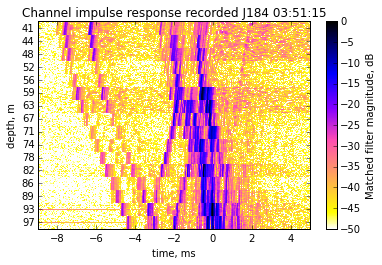

In [21]:
#calculate and plot matched filter result
mf = mf_bytime(tof, loadDuration, baseband=True)
fig,ax=plotMultipleChannel(mf, vmin=-50, tStart=-9, tEnd=5, norm='total')
plt.savefig(join(savefolder, 'full_response'))

In [22]:
look_theta = np.r_[thetaRange[0]:thetaRange[1]:numTheta*1j]
look_tau = np.r_[beamformingRange[0]:beamformingRange[1]:numBeams*1j]
look = beamform_attime(tof, look_theta, look_tau, uprate=5)

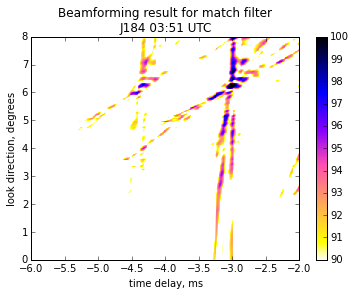

In [5]:
_ = plot_beamformer(look_theta, look_tau, look, mf.time,\
                   vmin=90, vmax = 100, normalize=False)
plt.savefig(join(savefolder, 'orig_beamformer'))

In [6]:
#create a time series of data
ts, snap_time = mf.single_index(5)
beam_time = ts.index[(ts.index > beamformingRange[0]) &
                  (ts.index < beamformingRange[1])]

In [7]:
max_angle = np.abs(look).max(0).idxmax()
ssp = getSoundSpeed(tof)
max_look = beamform(ts, ssp, max_angle, beam_time, uprate=5)

In [8]:
# signalBounds=(-4.48, -3.9)
signalBounds=(-4.48, -4.19)
# signalBounds=(-4.54, -4.19)
signalEstimate = max_look[(max_look.index > signalBounds[0]) &
                         (max_look.index < signalBounds[1])]

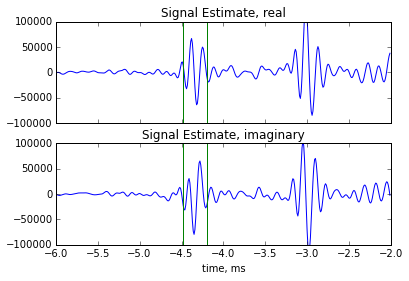

In [9]:
f, axarr = plt.subplots(2, sharex=True)
_=axarr[0].plot(max_look.index, np.real(max_look))
_=axarr[0].plot([signalBounds[0], signalBounds[0]],
                [-1e6, 1e6], 'g')
_=axarr[0].plot([signalBounds[1], signalBounds[1]],
                [-1e6, 1e6], 'g')

_=axarr[0].set_title('Signal Estimate, real')
_=axarr[0].set_ylim(-1e5, 1e5)

_=axarr[1].plot(max_look.index, np.imag(max_look))
_=axarr[1].plot([signalBounds[0], signalBounds[0]],
                [-1e6, 1e6], 'g')
_=axarr[1].plot([signalBounds[1], signalBounds[1]],
                [-1e6, 1e6], 'g')
_=axarr[1].set_title('Signal Estimate, imaginary')
_=axarr[1].set_ylim(-1e5, 1e5)

_=plt.xlabel('time, ms')
plt.savefig(join(savefolder, 'signal_est'))

In [10]:
#got this from mouse clicking
chan_xlim = np.array([[-4.8266129 , -3.66532258],
                   [-5.21370968, -3.90725806],
                   [-5.74596774, -4.18548387],
                   [-6.        , -4.36693548],
                   [-6.30241935, -4.75403226],
                   [-6.67741935, -5.05645161],
                   [-6.66532258, -5.46774194],
                   [-6.87096774, -5.70967742],
                   [-7.40322581, -6.07258065],
                   [-7.30645161, -6.39919355],
                   [-7.68145161, -6.55645161],
                   [-7.9233871 , -6.7016129 ],
                   [-7.79032258, -6.89516129],
                   [-8.12903226, -6.73790323],
                   [-8.35887097, -7.08870968],
                   [-8.45564516, -6.82258065]])

In [11]:
taxis = np.array(ts.index)
allchannels = np.array(ts)

est_sig = np.squeeze(np.array(signalEstimate))
auto_amp = np.sum(est_sig * est_sig.conj())

col_cor = lambda row: np.correlate(row, est_sig, mode='valid')
int_corr = np.apply_along_axis(col_cor, 0, allchannels)

corr_time = taxis[:-(est_sig.size-1)]

In [12]:
def apply_tochannel(xlim, channelNum):
    cropI = (corr_time > xlim[0]) &\
                      (corr_time < xlim[1])
    crop_time = corr_time[cropI]

    #NOTE ABS! Don't want amplitude to be able to change phase (??)
    #Trying real instead of abs
    interfer_amp = np.max(np.real(int_corr[cropI,channelNum]), axis=0) /\
                   auto_amp
    interferI = np.argmax(np.real(int_corr[cropI,channelNum]), axis=0) +\
                np.argmax(cropI)
    #without abs()
    interfer_phase = np.degrees(np.angle(int_corr[interferI,channelNum]))
    interfer_time = corr_time[interferI]
    return interfer_amp, interfer_phase, interferI

In [13]:
inter_all = []
for i, j in enumerate(chan_xlim):
    inter_all.append(apply_tochannel(j, i))
inter_all=np.array(inter_all)

In [14]:
erasedData = np.zeros(allchannels.shape, dtype='complex_')
eraser = np.zeros(allchannels.shape, dtype='complex_')

def erase_arrival(interInfo, channel):
    interferI = np.real(interInfo[2])
    interfer_amp = interInfo[0]
    eraser[interferI : (interferI + est_sig.size), channel] = est_sig
    eraser[:, channel] *= interfer_amp
    erasedData[:, channel] = allchannels[:, channel] - eraser[:, channel]
    
for i, j in enumerate(inter_all):
    erase_arrival(j, i)

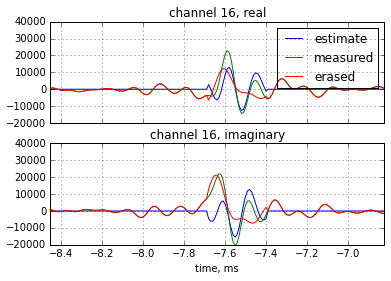

In [15]:
channelNum = 15
xlim = chan_xlim[channelNum]
#Verify that signal and eraser are properly lined up
f, axarr = plt.subplots(2, sharex = True)
_=axarr[0].plot(taxis, np.real(eraser[:, channelNum]), label='estimate')
_=axarr[0].plot(taxis, np.real(allchannels[:, channelNum]),\
                label='measured')
_=axarr[0].plot(taxis, np.real(erasedData[:, channelNum]),\
                label='erased')

_=axarr[0].set_xlim(xlim)
_=axarr[0].set_ylim(-2e4, 4e4)
_=axarr[0].set_title('channel %i, real'%(channelNum+1))
_=axarr[0].legend()
_=axarr[0].grid()


_=axarr[1].plot(taxis, np.imag(eraser[:, channelNum]))
_=axarr[1].plot(taxis, np.imag(allchannels[:, channelNum]))
_=axarr[1].plot(taxis, np.imag(erasedData[:, channelNum]))
_=axarr[1].set_xlim(xlim)
_=axarr[1].set_ylim(-2e4, 4e4)
_=axarr[1].set_xlabel('time, ms')

_=axarr[1].grid()
_=axarr[1].set_title('channel %i, imaginary'%(channelNum+1))
plt.savefig(join(savefolder, 'channel%i'%(channelNum+1)))

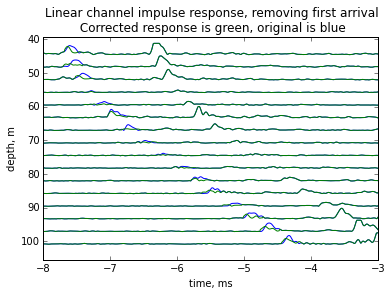

In [16]:
%autoreload
plotmax=3e4
orig_df = pd.DataFrame(allchannels, index=taxis, columns=mf.rd)
erased_df = pd.DataFrame(erasedData, index=taxis, columns=mf.rd)
# ax=plot_ts(crop_df, isDB=False, vmin = -1e4, vmax = 5e4, color='b')
# ax=plot_ts(erased_df, axis = ax, isDB=False,\
#                   vmin = -1e4, vmax = 5e4, color='g')
ax=plot_ts(orig_df, isDB=False,\
                  vmin = -plotmax, vmax = plotmax, color='b')
ax=plot_ts(erased_df, isDB=False, axis = ax,\
                  vmin = -plotmax, vmax = plotmax, color='g')
_=ax.set_xlim(-8, -3)
_=ax.set_title('Linear channel impulse response, removing first arrival'+
               '\n Corrected response is green, original is blue')
plt.savefig(join(savefolder, 'corrected_cir'))

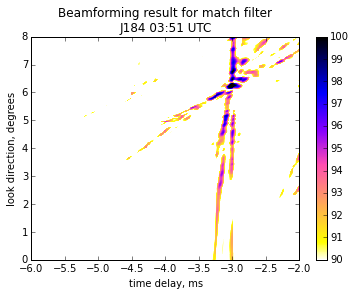

In [17]:
erased_look = beamform(erased_df, ssp, look_theta, look_tau, uprate=5)
_ = plot_beamformer(look_theta, look_tau, erased_look, mf.time,\
                   vmin=90, vmax = 100, normalize=False)
plt.savefig(join(savefolder, 'beamformer_corr'))